# Regresion logistica

En este notebook vamos a ajustar los datos a traves de una regresion logistica.  
Los supuestos del modelo lineal Y = β₀ + β₁ X + ε son que los errores ε tienen media poblacional cero y varianza constante, y que son independientes para distintas observaciones.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from preprocessing import cargarDatasets
from preprocessing import prepararSetDeEntrenamiento
from preprocessing import prepararSetDeValidacion
from preprocessing import ingenieriaDeFeauturesRegresion1
#from preprocessing import ingenieriaDeFeauturesRegresion2

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV

## Carga y preprocesamiento de los datos

Cargamos los datasets y preparamos los datos para entrenar la regresion.

In [2]:
train_df,final_df = cargarDatasets()
train_df = prepararSetDeEntrenamiento(train_df)
final_df = prepararSetDeValidacion(final_df)

In [3]:
X,y,df,y_encoder = ingenieriaDeFeauturesRegresion1(train_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)

Queremos encontrar los mejores hiperparametros para la regresion. Con estos hiperparametros buscamos minimizar el error en las predicciones, construyendo un modelo robusto y regularizado, para que logre generalizar para datos futuros. Como buscamos elegir el modelo con mejor AUC score, los hiperparametros con los que entrenaremos a la regresion seran los que maximicen el mismo.

Parametros:
* C -> que tanto regularizamos. Similar al C de SVM, cuanto mas pequenio este valor mas fuerte sera la regularizacion.  
* penalty -> tipo de regularizacion, estas pueden ser l1 (lasso), l2 (ridge) o elastic net.


In [4]:
params = [
    {'penalty' : ['l1','l2','elasticnet'],
     'C' : [0.001,0.005,0.01,0.05,0.1,0.3,1,3,5,10,30,50,55,75,100,120,150,],   
    }]

In [5]:
regresion = LogisticRegression(random_state = 0)

gscv = GridSearchCV(
    regresion, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [6]:
regresion.fit(X_train, y_train)
y_pred = regresion.predict(X_test)

In [7]:
print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.892964190294417
Best params {'C': 0.1, 'penalty': 'l2'}


## Evaluacion de metricas  
Las metricas a utilizar son:
* AUC-ROC  
* Matriz de confusión  
* Accuracy  
* Precisión  
* Recall 
Primero observamos las metricas obtenidas de las predicciones con el set de prueba.

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, regresion.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2473
           1       0.72      0.56      0.63       784

    accuracy                           0.84      3257
   macro avg       0.80      0.75      0.77      3257
weighted avg       0.83      0.84      0.83      3257



**conclusion maybe**

### Curva AUC ROC

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, regresion.predict_proba(X_test)[:,1]) #creo que esto es al pedo

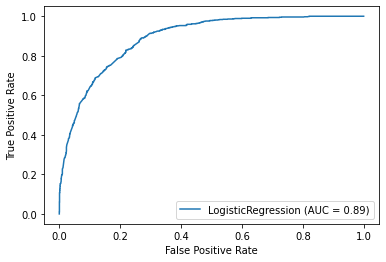

In [11]:
plot_roc_curve(regresion,X_test,y_test,response_method='predict_proba')
plt.show()

**conclusion**

### Matriz de confusion

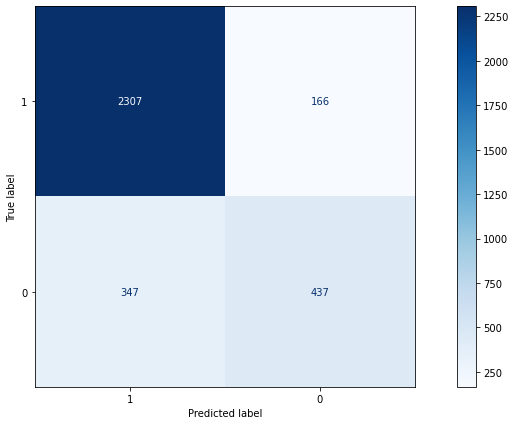

In [12]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    regresion, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax
)
plt.show()

### Accuracy

In [13]:
accuracy_score(y_test, y_pred) 

0.842493091802272

### Precision

In [14]:
precision_score(y_test, y_pred)

0.724709784411277

### Recall

In [15]:
recall_score(y_test, y_pred)

0.5573979591836735

In [16]:
regresionFinal = LogisticRegression(penalty = 'l2',C = 0.1, random_state = 0)
regresionFinal.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=0)

### Residual plot
Queremos observar que los residuos cumplan con los supuestos del modelo. Si no se cumplen, tal vez el modelo lineal no sea lo mejor para predecir

<AxesSubplot:xlabel='Predicciones', ylabel='Residuos'>

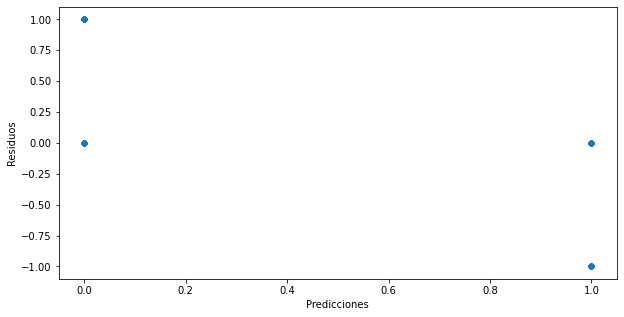

In [17]:
plt.rcParams['figure.figsize'] = (10, 5)

preds = pd.DataFrame({"Predicciones": y_pred, "true": y_test})
preds["Residuos"] = preds["true"] - preds["Predicciones"]
preds.plot(x="Predicciones", y="Residuos", kind="scatter")

**creo que hay un patron**

## Predicciones sobre el set de hold out

In [ ]:
#falta preprocesamiento de los datos.

ho_prediction = arbol_1.predict(final_df)
final_df['tiene_alto_valor_adquisitivo'] = ho_prediction